## Проверка систем сплитования

Предположим, что наш продукт это мобильное приложение. У нас есть база данных на ClickHouse. Все пользователи приложения делятся на группы (exp_group) для проведения экспериментов. Прежде чем проводить эксперименты, мы должны убедиться в том, что группы между собой не различаются.  

In [1]:
# импортируем нужные для работы библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
from scipy import stats

In [2]:
# подключимся к базе данных
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'simulator_20220120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = "select user_id, countIf(user_id, action = 'like') as like, countIf(user_id, action = 'view') as view, like/view as ctr, exp_group from {db}.feed_actions where (toDate(time) between '2022-01-07' and '2022-01-13') and exp_group in (2, 3) group by user_id, exp_group"
df = ph.read_clickhouse(query, connection=connection)

In [3]:
# посмотрим на наши данные
df

,user_id,like,view,ctr,exp_group
0,115383,11,36,0.305556,3
1,123580,15,92,0.163043,3
2,131473,26,148,0.175676,2
3,23985,12,66,0.181818,2
4,24523,17,120,0.141667,2
...,...,...,...,...,...
17044,122008,4,31,0.129032,3
17045,25383,16,57,0.280702,2
17046,122190,25,74,0.337838,3
17047,108927,8,33,0.242424,2


Проверим гипотезу, что CTR второй и третьей группы статистически не различаются

### Сделаем симуляцию, как будто мы провели 10000 АА тестов и посмотрим в каком количестве случаев нам удалось отклонить нулевую гипотезу

In [4]:
def get_global_ctr(ctr_data, n_samples = 10000):
    global_ctr_data = []
    for i in range(n_samples):
        resample_data = ctr_data.sample(frac = 0.05, replace = True)
        global_ctr = resample_data.like.sum() / resample_data.view.sum()
        global_ctr_data.append(global_ctr)
    
    sns.displot(global_ctr_data)
    return [
        pd.Series(global_ctr_data).quantile(0.05),
        pd.Series(global_ctr_data).mean(),
        pd.Series(global_ctr_data).quantile(0.95)
    ]

[0.2055424359846022, 0.2114164138764017, 0.21733736201880827]

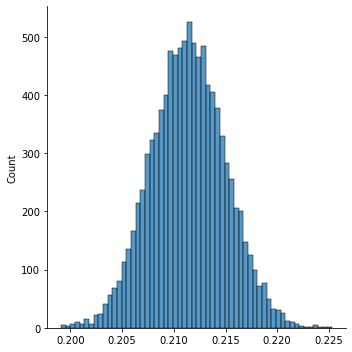

In [5]:
get_global_ctr(df[df.exp_group == 2])

[0.20485336333971052, 0.21076785341214876, 0.21666411668074456]

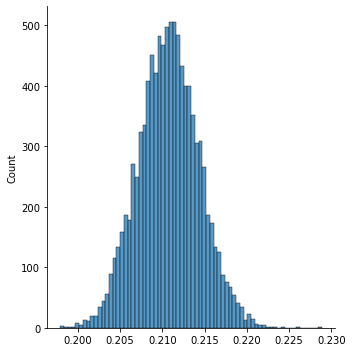

In [6]:
get_global_ctr(df[df.exp_group == 3])

Видим, что границы доверительного интервала практически совпадают. Можно сделать вывод, что global ctr между группами 2 и 3 не различаются 

In [13]:
# Проведем t-test для 10000 подвыборок из 500 юзеров
p_values_ctr = []
for i in range(10000):
    exp_group2 = df[df.exp_group == 2].sample(frac = 0.05, replace=True).ctr.values
    exp_group3 = df[df.exp_group == 3].sample(frac = 0.05, replace=True).ctr.values
    p_value = stats.ttest_ind(exp_group2, exp_group3, equal_var = False)[1]
    p_values_ctr.append(p_value)

Построим гистограмму распределения получившихся 10000 p-values

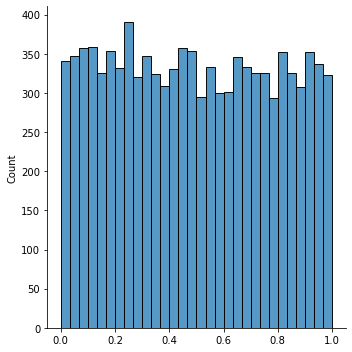

In [14]:
sns.displot(p_values_ctr, bins=30, kde=False)

Посчитаем, какой процент p values оказался меньше либо равен 0.05

In [15]:
(pd.Series(p_values_ctr) <= 0.05).sum() / 10000 * 100

5.029999999999999

Вывод: 

Из 10000 подвыборок, в 5% случаев p-values меньше или равно 0.05. Можно сделать вывод, что система сплитования работает корректно.